
# **Group 37 STAT-201 Project Proposal**: Exploring Salaries of Data Science Professionals


## Introduction
Data science professionals have gained flexibility in recent years in regards to how they work — with more choosing to work hybrid remote or fully remote instead of spending their days in the office. Furthermore, reports suggest that data science is one of the areas in tech with the fastest growing salaries (Sendall, Peslak, Ceccucci, & Hunsinger, 2022, p. 32). 

With these notions in mind, how do salaries compare across in-person, hybrid, and fully remote workers?

 We found a dataset of 607 data science professionals (Data Science Job Salaries, 2022) to help us answer this question. Each observation in the data has the following variables: the year the observation was recorded; the job title of the worker; their country of residence; their salary; their experience level; their ratio of remote work; the country of their employer; the location of the employer; and the size of their company. 

The variables of interest in helping us answer our question are salary and the ratio of remote work. In this dataset, the ratio of remote work is a categorical variable that is either 0%, 50%, or 100%. These ratios are equivalent to the qualitative labels of ‘in-person’, ‘hybrid’, or ‘fully 
remote’. 

To actually answer the question, we will be computing the mean salary and standard deviation of the salary for each group of remote work done. Also, we are going to calculate the confidence interval of each group and conduct the null hypothesis: all groups are equal and the alternative hypothesis test: at least one of them is different.  Based on the p-value that we calculated, we will either reject or fail to reject the null hypothesis that all three groups of data scientists have the same salaries. 


## Methods and Results
### Exploratory Analysis
First we will load, clean, and wrangle the data as well as perform exploratory analysis.

Below we have loaded all the libraries that we need.

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(dplyr)))
suppressWarnings(suppressMessages(library(infer)))
suppressWarnings(suppressMessages(library(broom)))



#### Reading Data

Note that the original dataset had a column to index the rows, hence the column name `...1`

In [2]:
salary_data <- read_csv("https://raw.githubusercontent.com/william-swy/stat_201_project/main/ds_salaries.csv", show_col_types = FALSE)
head(salary_data)

New names:
• `` -> `...1`


...1,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


#### Cleaning and Wrangling Data

The column `remote_ratio` consists of three values: `0`, `50`, `100`, which represent "in-person", "hybrid" and "remote" respectively, it makes more sense to represent the column
as a factor.

In [3]:
unique(salary_data[c("remote_ratio")])

remote_ratio
<dbl>
0
50
100


In [4]:

salary_data_clean <- salary_data %>%
                     mutate(remote_ratio = factor(remote_ratio)) %>%
                     mutate(remote_ratio = recode(remote_ratio, `0` = "in-person", `50` = "hybrid", `100` = "remote")) %>%
                     select(-...1)
head(salary_data_clean)

work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>,<chr>,<chr>
2020,MI,FT,Data Scientist,70000,EUR,79833,DE,in-person,DE,L
2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,in-person,JP,S
2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,hybrid,GB,M
2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,in-person,HN,S
2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,hybrid,US,L
2020,EN,FT,Data Analyst,72000,USD,72000,US,remote,US,L


#### Relevant Plots

It is helpful to see the distributions of the three different remote levels. From **Figure 1**, it seems that the means for all three different remote levels are relatively close to each other. One thing to note from the histogram is that the sample has a significant larger proportion of remote workers compared to both in-person and hybrid.

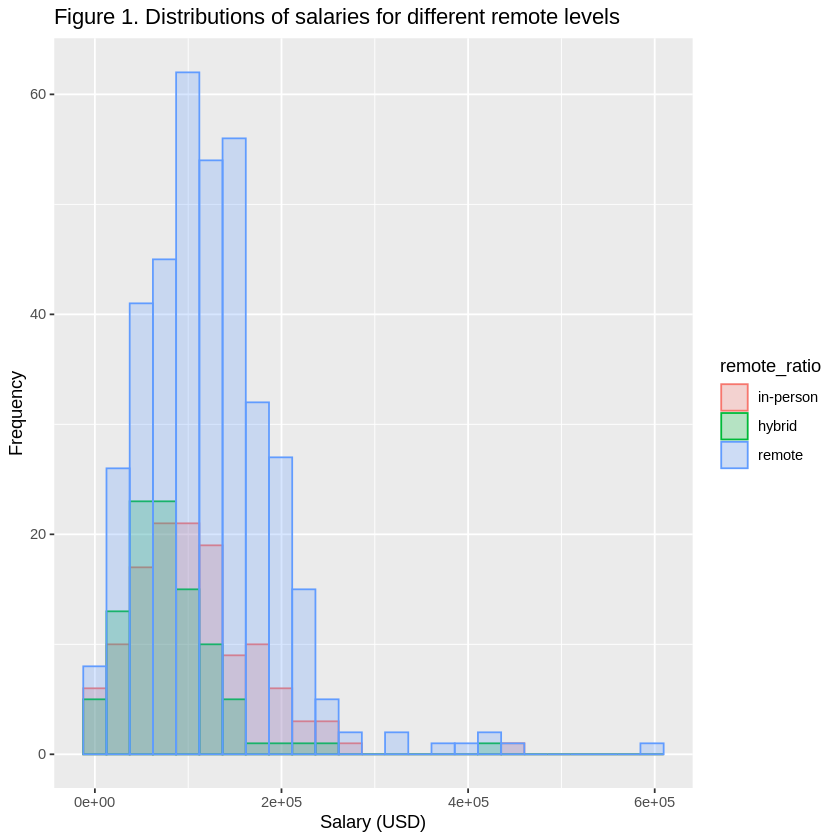

In [5]:
salary_remote_lvl_histogram <- 
                    salary_data_clean %>% 
                    ggplot() +
                    geom_histogram(aes(salary_in_usd, color=remote_ratio, fill=remote_ratio), alpha=.25, bins=25, position="identity") +
                    xlab("Salary (USD)") +
                    ylab("Frequency") +
                    ggtitle("Figure 1. Distributions of salaries for different remote levels")
salary_remote_lvl_histogram

To make the visual comparison of centers and spreads easier, a box plot was created.

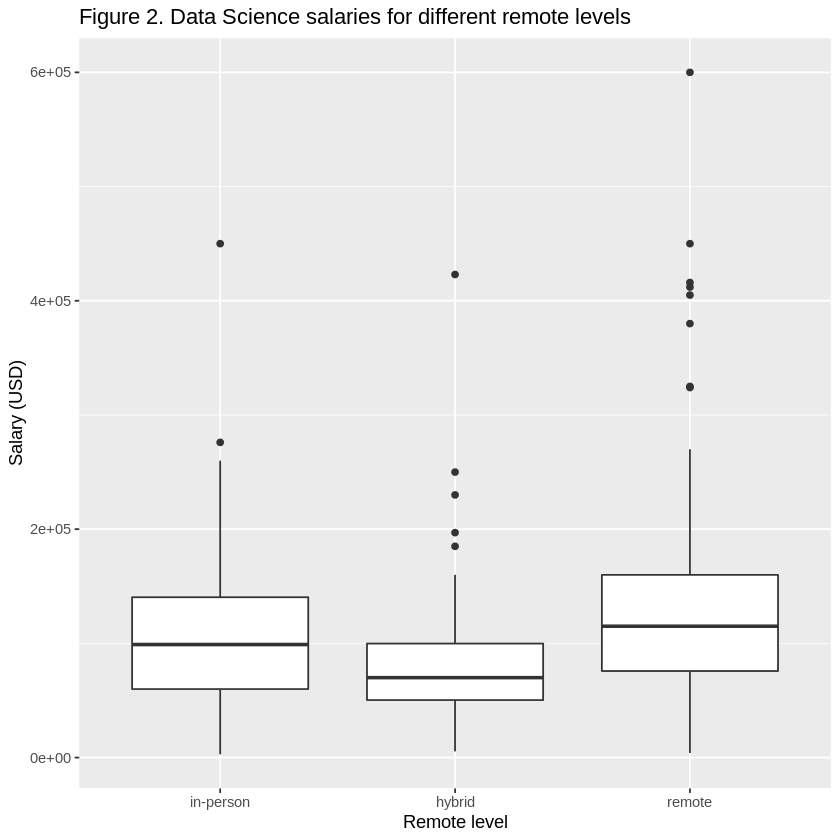

In [6]:
salary_remote_lvl_boxplot <- 
    salary_data_clean %>%
    ggplot(aes(x = remote_ratio, y = salary_in_usd)) +
    geom_boxplot() + 
    xlab("Remote level") +
    ylab("Salary (USD)") +
    ggtitle("Figure 2. Data Science salaries for different remote levels")
salary_remote_lvl_boxplot

#### Parameter Estimates
Below we will compute the mean and standard deviation of each group's salary.

In [7]:
mean_sd_table <- salary_data_clean %>%
group_by(remote_ratio) %>%
summarize(mean_salary = mean(salary_in_usd), salary_sd = sd(salary_in_usd), n = n())
mean_sd_table

remote_ratio,mean_salary,salary_sd,n
<fct>,<dbl>,<dbl>,<int>
in-person,106354.62,67724.54,127
hybrid,80823.03,57353.09,99
remote,122457.45,72710.84,381


### Confidence Intervals and Hypothesis Testing
To actually answer our question we will use two approaches: confidence intervals and hypothesis tests. 

Confidence intervals will show us if there is any overlap between the middle 95% of observations in each group. For a pair of groups, if there isn't any overlap in their confidence intervals, it suggests that the population parameters(in our case, the means) of the groups are different. 

Hypothesis tests, on the other hand, will allow us to check our assertion that the means are different in a methodical way. We will assume that the means are the same, and calculate the probability of our results given this assumption. If the probability is low, we will be inclined to reject the hypothesis that the means are the same. 

#### Confidence Intervals
Below we will use the infer package to calculate a 95% confidence interval for each group mean. We chose a 95% interval because that is the most common and practical interval. We will be using both bootstrap and asymptotic methods to calculate the CI's so we can compare the two methods.

In [8]:
set.seed(1234) # must set seed as bootstrapping is random


#compute in-person ci using bootstrapping
in_person_ci_bootstrap <- salary_data_clean %>% filter(remote_ratio == 'in-person') %>% specify(response = salary_in_usd)  %>% 
    generate(reps = 1000) %>%
    calculate(stat = 'mean') %>%
    get_confidence_interval(level = 0.95, type='percentile')

#compute hybrid ci using bootstrapping
hybrid_ci_bootstrap <- salary_data_clean %>% filter(remote_ratio == 'hybrid') %>% specify(response = salary_in_usd)  %>% 
    generate(reps = 1000) %>%
    calculate(stat = 'mean') %>%
    get_confidence_interval(level = 0.95, type='percentile')

#compute remote ci using bootstrapping
remote_ci_bootstrap <- salary_data_clean %>% filter(remote_ratio == 'remote') %>% specify(response = salary_in_usd)  %>% 
    generate(reps = 1000) %>%
    calculate(stat = 'mean') %>%
    get_confidence_interval(level = 0.95, type='percentile')

#now we will compute intervals using asymptotics. 
#store values needed for in-person asymptotic interval
in_person_mean <- filter(mean_sd_table, remote_ratio == 'in-person')$mean_salary
in_person_n <- filter(mean_sd_table, remote_ratio == 'in-person')$n
in_person_std_error <- filter(mean_sd_table, remote_ratio == 'in-person')$salary_sd / sqrt(in_person_n)

#use t-distribution to compute lower and upper ci 
in_person_ci_asymptotics <- tibble(
        lower_ci = qt(0.025, df = in_person_n - 1) * in_person_std_error + in_person_mean,
        upper_ci = qt(0.975, df = in_person_n - 1) * in_person_std_error + in_person_mean
)


#store values needed for hybrid asymptotic interval
hybrid_mean <- filter(mean_sd_table, remote_ratio == 'hybrid')$mean_salary
hybrid_n <- filter(mean_sd_table, remote_ratio == 'hybrid')$n
hybrid_std_error <- filter(mean_sd_table, remote_ratio == 'hybrid')$salary_sd / sqrt(hybrid_n)

#use t-distribution to compute lower and upper ci 
hybrid_ci_asymptotics <- tibble(
        lower_ci = qt(0.025, df = hybrid_n - 1) * hybrid_std_error + hybrid_mean,
        upper_ci = qt(0.975, df = hybrid_n - 1) * hybrid_std_error + hybrid_mean
)

#store values needed for remote asymptotic interval
remote_mean <- filter(mean_sd_table, remote_ratio == 'remote')$mean_salary
remote_n <- filter(mean_sd_table, remote_ratio == 'remote')$n
remote_std_error <- filter(mean_sd_table, remote_ratio == 'remote')$salary_sd / sqrt(remote_n)

#use t-distribution to compute lower and upper ci 
remote_ci_asymptotics <- tibble(
        lower_ci = qt(0.025, df = remote_n - 1) * remote_std_error + remote_mean,
        upper_ci = qt(0.975, df = remote_n - 1) * remote_std_error + remote_mean
)


#combine everything into one summary table and rename columns. 
bootstrap_cis <- bind_rows(in_person_ci_bootstrap, hybrid_ci_bootstrap, remote_ci_bootstrap)
asymptotic_cis <- bind_rows(in_person_ci_asymptotics, hybrid_ci_asymptotics, remote_ci_asymptotics) 
salary_summary_table <- cbind(mean_sd_table, bootstrap_cis, asymptotic_cis)
colnames(salary_summary_table)[5] <- 'lower_ci_bootstrap'
colnames(salary_summary_table)[6] <- 'upper_ci_bootstrap'
colnames(salary_summary_table)[7] <- 'lower_ci_asymptotics'
colnames(salary_summary_table)[8] <-  'upper_ci_asymptotics'
salary_summary_table

Setting `type = "bootstrap"` in `generate()`.

Setting `type = "bootstrap"` in `generate()`.

Setting `type = "bootstrap"` in `generate()`.



remote_ratio,mean_salary,salary_sd,n,lower_ci_bootstrap,upper_ci_bootstrap,lower_ci_asymptotics,upper_ci_asymptotics
<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
in-person,106354.62,67724.54,127,94701.39,119344.37,94461.84,118247.4
hybrid,80823.03,57353.09,99,70105.89,92268.02,69384.16,92261.9
remote,122457.45,72710.84,381,115491.82,129564.14,115133.09,129781.8


As we can see above, the bootstrap confidence intervals are very similar to the asymptotic confidence intervals. This suggests that our use of the Central Limit Theorem when using asymptotics fulfilled all the neccessary prerequisites.

#### Visualizing the Confidence Interval 
Below we will visualize our confidence intervals. 

Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




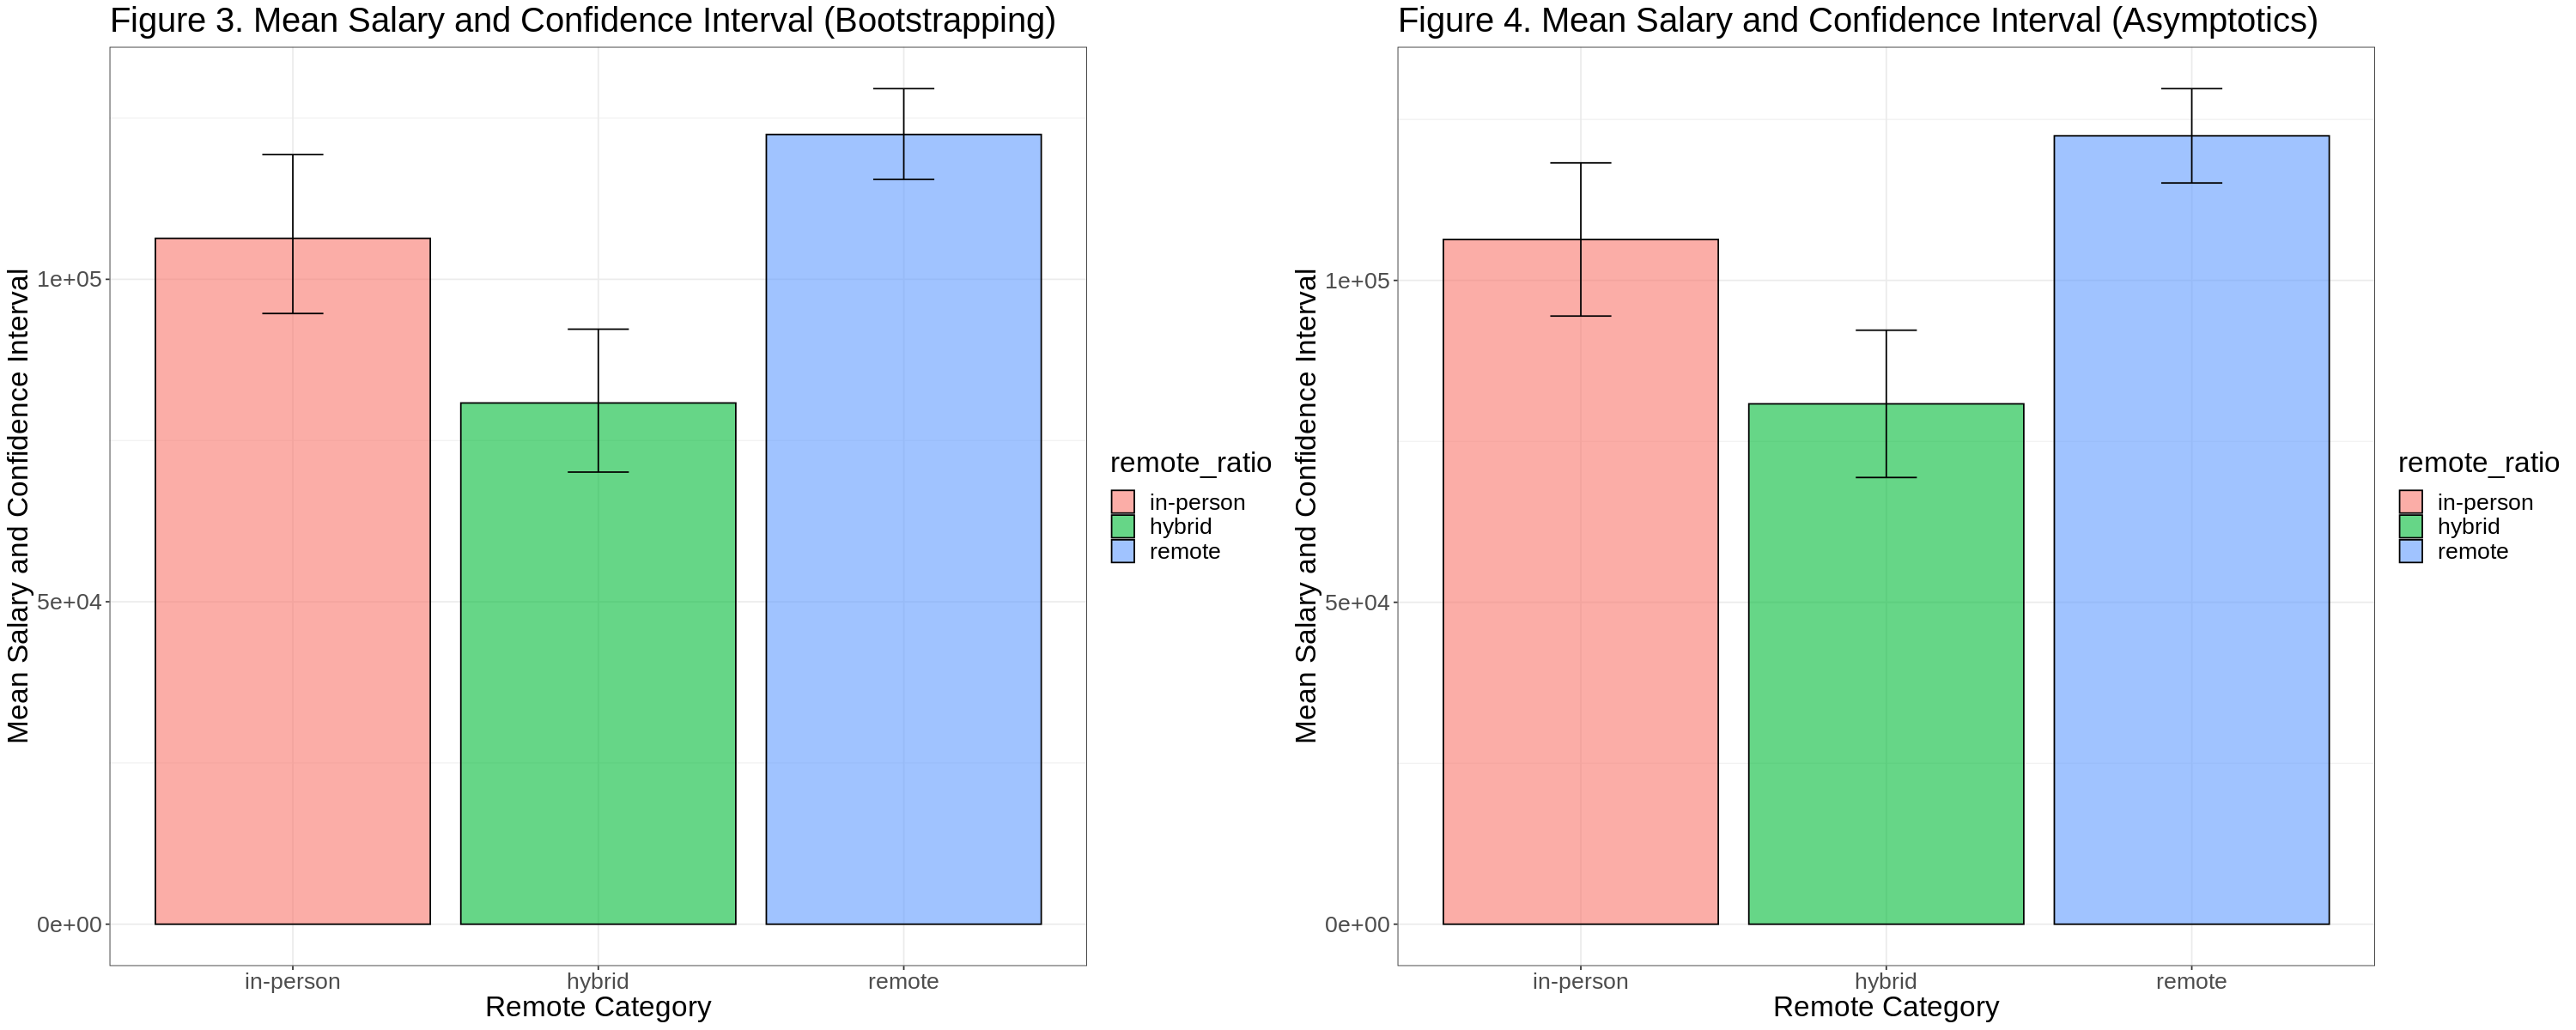

In [9]:
require(gridExtra)
options(repr.plot.width = 25, repr.plot.height = 10)

salary_ci_plot_bootstrap <- 
    salary_summary_table %>% 
    ggplot(aes(x = remote_ratio, y = mean_salary, fill=remote_ratio)) +
      geom_bar(stat = "identity", 
               colour="black",
               alpha = .6) +
      geom_errorbar(aes(ymin = lower_ci_bootstrap, ymax = upper_ci_bootstrap), # uses bootstrap intervals
                    size = 0.5, color = "black", width=.2) +
      theme_bw() +
      xlab("Remote Category") +
      ylab("Mean Salary and Confidence Interval") +
      theme(text = element_text(size = 20)) + 
      ggtitle("Figure 3. Mean Salary and Confidence Interval (Bootstrapping) ")

salary_ci_plot_asymptotics <- 
    salary_summary_table %>% 
    ggplot(aes(x = remote_ratio, y = mean_salary, fill=remote_ratio)) +
      geom_bar(stat = "identity", 
               colour="black",
               alpha = .6) +
      geom_errorbar(aes(ymin = lower_ci_asymptotics, ymax = upper_ci_asymptotics), # changed to use asymptotic intervals
                    size = 0.5, color = "black", width=.2) +
      theme_bw() +
      xlab("Remote Category") +
      ylab("Mean Salary and Confidence Interval") +
      theme(text = element_text(size = 20)) + 
      ggtitle("Figure 4. Mean Salary and Confidence Interval (Asymptotics) ")

grid.arrange(salary_ci_plot_bootstrap,
salary_ci_plot_asymptotics, ncol = 2)

#### Hypothesis Testing (ANOVA Test)
We are going to use the ANOVA test to check if the salaries of the three groups are the same or different. Our null hypothesis will be that in-person, hybrid and fully remote workers earn the same salary, and our alternative hypothesis will be that at least one of those groups of workers earns a different salary. 

The `aov()` function in R will perform the ANOVA test for us and generate the p-value. Remember that the p-value is the probability of getting our results if the null hypothesis is true. 

The significance level we have chosen is the most common 5% significance level. We are going to reject the null hypothesis if the p-value is lower than the significance level and fail to reject the null hypothesis if the p-value is higher than the significance level.


In [10]:
# ANOVA
aov(salary_in_usd~remote_ratio, data = salary_data_clean) %>% tidy()

term,df,sumsq,meansq,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
remote_ratio,2,1.418875e+11,70943770169,14.72873,5.681751e-07
Residuals,604,2.909282e+12,4816691479,NA,NA


### Discussion

As shown in table (INSERT NUMBER), the p-value was determined to be 5.681751e-07. Under a 5% significance level, we have enough evidence to reject the null hypothesis. The low value of the p-value shows that it is quite unlikely to get the observed test statistic if the null hypothesis were true, which suggests rejecting the null hypothesis. This implies that there is at least one remote level that has a mean salary different from the other remote levels. To some extent this is also intuitively reflected in the confidence intervals shown in table (INSERT NUMBER) as the confidence intervals for hybrid and remote have no intersection.

To an extent this result was expected since from figure 2, hybrid has intuitively lower mean than the other categories. The ANOVA test confirmed this intuition.

One future question might include whether correlation among different variables is involved which would skew our analysis. Another future question is whether productivity is any different between different levels of remote work, and whether certain groups of workers deserve higher wages.




### References

*Data Science Job Salaries*. Kaggle. (2022, June 15). Retrieved July 26, 2022, from https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries 

King, J., & Magoulas, R. (2015). *Data Science Salary Survey*. O'Reilly Media, Incorporated.

Sendall, P., Peslak, A., Ceccucci, W., & Hunsinger, D. S. (2022). The COVID-19 Pandemic’s Impact on Information Technology Employment, Salaries, and Career Opportunities. *JOURNAL OF INFORMATION SYSTEMS APPLIED RESEARCH.*
